In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [2]:
dataset = pd.read_csv("Data Collection.csv")

rows = list(dataset.axes[0])
columns = list(dataset.axes[1])
print('Row Count: ', len(rows))
print('Column Count: ', len(columns))

dataset.head()

Row Count:  150
Column Count:  8


,Speaker,Gender,Word,Phoneme,Time,Formant1,Formant2,Formant3
0,alw001,F,heed,IY,0.931746,380.739503,2523.079518,3234.430697
1,alw001,F,hid,IH,2.014639,479.727255,2715.679948,3338.660600
2,alw001,F,head,EH,3.003640,735.340230,2300.468502,3159.912711
3,cxb001,F,heed,IY,0.828268,355.837818,2821.359346,3911.313367
4,cxb001,F,hid,IH,1.415768,360.737197,2849.009182,3259.985862


Text(0.5, 1.03, 'Distributions of Formants')

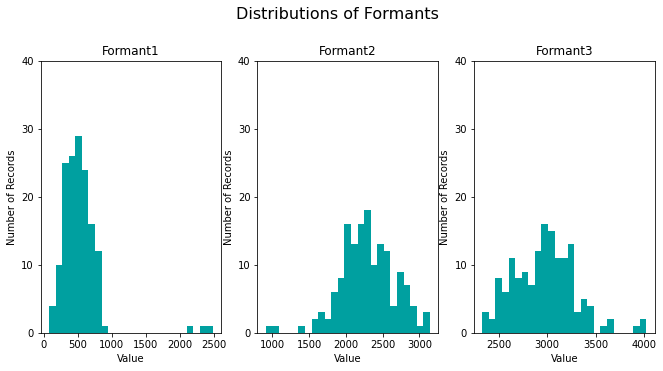

In [3]:
# Create figure
fig = plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(1, 3)
# Skewed feature plotting
for i, feature in enumerate(['Formant1', 'Formant2', 'Formant3']):
    ax = plt.subplot(gs[0, i]) #
    ax.hist(dataset[feature], bins=25, color='#00A0A0')
    ax.set_title(feature)#, fontsize=14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 40))
    ax.set_yticks([0, 10, 20, 30, 40])

# Plot aesthetics
fig.suptitle("Distributions of Formants", fontsize=16, y=1.03)

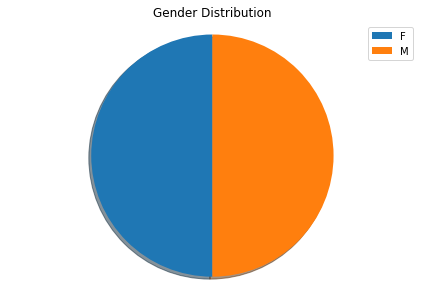

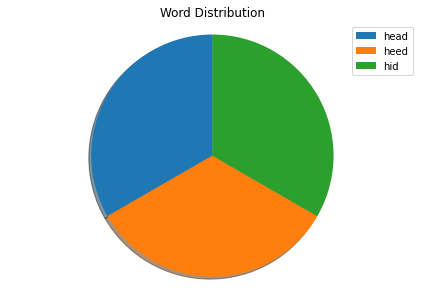

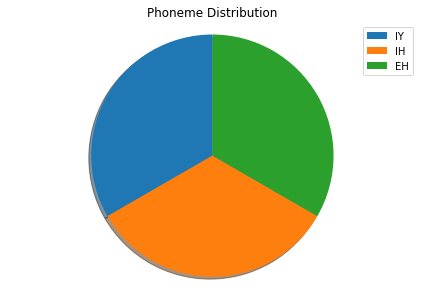

In [4]:
def FeatureDistribution(df:pd.DataFrame, feature:str):
    # Visualizing Activity Distribution
    temp = df[feature].value_counts()
    df = pd.DataFrame({'labels': temp.index,
                       'values': temp.values
                      })

    labels = df['labels']
    sizes = df['values']
    patches, texts = plt.pie(sizes, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title(feature + " Distribution")
    plt.show()

FeatureDistribution(dataset, "Gender")
FeatureDistribution(dataset, "Word")
FeatureDistribution(dataset, "Phoneme")

In [5]:
phoneme_encode =    {
                        "IY":0,
                        "IH":1,
                        "EH":2,
                    }

word_encode =   {
                    "heed":0,
                    "hid":1,
                    "head":2,
                }

gender_encode = {
                    "F": 0,
                    "M": 1
                }

In [6]:
dataset['Word'] = dataset['Word'].map(word_encode)
dataset['Gender'] = dataset['Gender'].map(gender_encode)
dataset['Phoneme'] = dataset['Phoneme'].map(phoneme_encode)

In [7]:
phonome = dataset['Phoneme']
dataset = pd.DataFrame(dataset.drop(['Speaker', 'Time', 'Phoneme'],axis=1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, phonome, test_size=0.25, random_state=0)

In [9]:
clf = KNeighborsClassifier()

parameters =    {
                "n_neighbors": [1, 3, 5, 10, 20],
    # simply change p for 3 distance metrics
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric
                "p": [1, 2, 3],
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

print('The parameters combination that would give best accuracy is : ')
print(grid_fit.best_params_)

The parameters combination that would give best accuracy is : 
{'n_neighbors': 1, 'p': 1}


In [10]:
parameters =    {
                "n_neighbors": [3, 5, 10, 20],
    # simply change p for 3 distance metrics
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric
                "p": [1, 2, 3],
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

print('The parameters combination that would give best accuracy is : ')
print(grid_fit.best_params_)
print()
# Get the estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train, y_train)
# Make predictions using the unoptimized and model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions, average='weighted')))

The parameters combination that would give best accuracy is : 
{'n_neighbors': 10, 'p': 1}

Unoptimized model
------
Accuracy score on the testing data: 0.7105
F-score on the testing data: 0.6923
Precision score on the testing data: 0.6919
Recall score on the testing data: 0.7105

Optimized Model
------
Final accuracy score on the testing data: 0.7632
Final F-score on the testing data: 0.7567
Final precision score on the testing data: 0.7557
Final recall score on the testing data: 0.7632


Confusion matrix, without normalization
[[15  1  0]
 [ 2  6  3]
 [ 0  3  8]]


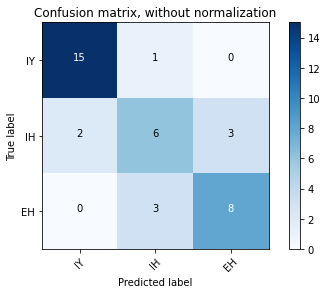

In [11]:
# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=phoneme_encode, title='Confusion matrix, without normalization')

In [12]:
dataset['Phoneme'] = phonome
dataset = dataset[dataset['Gender'] == 0]
phonome = dataset['Phoneme']
dataset = pd.DataFrame(dataset.drop(['Phoneme'],axis=1))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataset, phonome, test_size=0.25, random_state=0)


In [14]:
clf = KNeighborsClassifier()

parameters =    {
                "n_neighbors": [3, 5, 10, 20],
    # simply change p for 3 distance metrics
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric
                "p": [1, 2, 3],
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

print('The parameters combination that would give best accuracy is : ')
print(grid_fit.best_params_)
print()
# Get the estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train, y_train)
# Make predictions using the unoptimized and model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions, average='weighted')))

The parameters combination that would give best accuracy is : 
{'n_neighbors': 5, 'p': 1}

Unoptimized model
------
Accuracy score on the testing data: 0.6316
F-score on the testing data: 0.6226
Precision score on the testing data: 0.6711
Recall score on the testing data: 0.6316

Optimized Model
------
Final accuracy score on the testing data: 0.5789
Final F-score on the testing data: 0.5498
Final precision score on the testing data: 0.6165
Final recall score on the testing data: 0.5789


Confusion matrix, without normalization
[[6 0 0]
 [3 2 4]
 [0 1 3]]


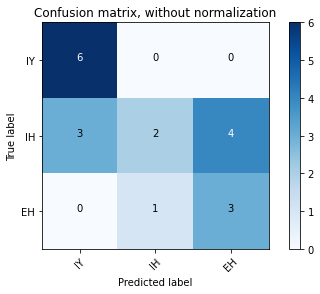

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=phoneme_encode, title='Confusion matrix, without normalization')
